In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import exp, abs, log
from scipy.special import gamma, factorial
import os
import scipy.stats as stats
import statsmodels.api as sm
from utils import *
import time
import datetime as dt
import universal as up
from universal import tools, algos
from universal.algos import *
from strategies import *
from metrics import *
import universal as up
from universal import tools, algos
from universal.result import AlgoResult, ListResult

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=np.inf)

In [2]:
paras={'dataset':'snp500-12', 'maxiter':5000, 'subn':100, 'lb':5, 'M':20, 'inverse':'True', 'ggd':'True', 'matcnt':30, 
       'c':0.001, 'rf':1e-3, 'opt_gamma':3, 'passive_eps':1.001, 'passive_delta':0.01}

In [3]:
maxiter, subn, lb, c = paras['maxiter'], paras['subn'], paras['lb'], paras['c']

X_lst = []
for phs in range(0, 12):
# phs=0
    if paras['dataset']=='snp500-12':
        data_path1 = './stock_data/stock_phase%02d_lb%d.npz' % (phs, lb)
    elif paras['dataset']=='snp500-24':
        data_path1 = './stock_data/stock24_phase%02d_lb%d.npz' % (phs, lb)
    data = np.load(data_path1)
    cov_train, choice = data['cov_train'], data['choice']
    cov = cov_train[choice[:subn], :][:, choice[:subn]]

    predY0, std_varY0, sample_Y0 = get_res(paras, phs, maxiter, subn, lb)

    X = np.concatenate([v.reshape(1,-1) for v in sample_Y0], axis=0)
    X = exp(X)
    X_lst.append(X)
    
X = np.concatenate(X_lst, axis=0)

In [4]:
X = pd.DataFrame(X)

In [5]:
X

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.002105,0.997816,1.000338,1.009804,0.994072,0.998862,1.017619,1.022479,1.014381,0.992551,...,1.002263,0.988653,0.985095,1.013618,0.993119,1.006099,0.964348,1.017056,0.997823,0.995473
1,0.993067,0.976155,0.981738,0.995146,0.996064,0.985646,1.045014,0.994247,0.982673,0.992707,...,0.997252,0.970159,1.008812,0.963409,0.995381,0.997468,0.991178,0.986553,0.994910,0.994442
2,1.008674,1.019825,1.021702,1.004878,0.988386,0.992834,0.991505,0.998790,1.020197,1.011499,...,0.997047,0.986234,0.996782,1.012551,1.020108,1.034000,1.012150,1.003849,0.999756,1.013211
3,1.015940,0.997454,0.999326,1.004854,1.016838,1.003958,1.012761,1.001448,1.016781,1.003053,...,0.996446,0.989313,1.005131,1.000324,1.012889,1.001190,0.992811,1.004792,1.003168,1.009027
4,0.991123,0.990835,0.993927,0.985507,1.006135,0.992579,0.988640,0.998052,0.992830,0.975653,...,0.985833,0.991402,0.996329,1.003482,1.002994,0.991604,0.977153,0.994118,0.998543,1.003479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1.005663,0.994244,1.029340,1.007429,1.015449,1.006376,0.994350,1.027563,0.973881,0.985081,...,1.028489,1.000275,0.983402,0.994845,0.988217,1.003661,1.013858,1.009510,1.007965,0.993761
1196,0.997275,0.971664,0.990974,0.967552,0.984396,0.978059,0.881119,0.938484,0.919540,0.961450,...,0.975090,0.943825,0.989734,0.982153,0.957115,0.953544,0.966633,0.976184,0.967921,0.974889
1197,0.997086,1.005958,1.009588,1.001905,1.013077,1.013196,1.021825,1.041159,1.066667,1.032458,...,1.008992,1.024362,1.034107,1.001172,0.998594,1.007808,1.022042,1.011548,1.016815,1.012818
1198,0.994337,1.002494,1.022792,0.995436,1.003520,1.016694,1.013107,1.009517,0.976562,0.987517,...,0.988252,0.990886,0.984869,0.980094,0.996982,1.012395,1.012614,1.010827,0.986818,1.000960


In [6]:
def run(paras, strategy_lst, figsize=(10,5), phase_cnt=12):
    maxiter, subn, lb, c = paras['maxiter'], paras['subn'], paras['lb'], paras['c']

    results = []
    concat_result_dict = {}
    for phs in range(0, phase_cnt):
        print('Phase %d' % phs)
        if paras['dataset']=='snp500-12':
            data_path1 = './stock_data/stock_phase%02d_lb%d.npz' % (phs, lb)
        elif paras['dataset']=='snp500-24':
            data_path1 = './stock_data/stock24_phase%02d_lb%d.npz' % (phs, lb)
        data = np.load(data_path1)
        cov_train, choice = data['cov_train'], data['choice']
        cov = cov_train[choice[:subn], :][:, choice[:subn]]

        print('Testing...')
        predY0, std_varY0, sample_Y0 = get_res(paras, phs, maxiter, subn, lb)
        
#         strategy_lst = ['ucb_strategy(0, predY0, std_varY0, sample_Y0)', 
#                         'opt_strategy(predY0, std_var_Y0, sample_Y0, cov, paras["opt_delta"])', 
#                         'passive_strategy(predY0, std_var_Y0, sample_Y0, cov, paras["passive_eps"], paras["passive_delta"])']
#         metrics_lst =['cumulative_return(rt_v)', 'daily_return(rt_v)', 'max_redraw(rt_v)']
        
        result_dict = {}        
        for strategy in strategy_lst:
            strategy_name = strategy.split('(')[0]
            print(strategy_name)
            rt_v, x_vec = eval(strategy)
            result_dict[strategy_name] = [rt_v, x_vec]
            if strategy_name in concat_result_dict:
                concat_result_dict[strategy_name][0] += rt_v
                concat_result_dict[strategy_name][1] += x_vec
            else:
                concat_result_dict[strategy_name] = [rt_v, x_vec]
#             for metric in metrics_lst:
#                 metric_name = metric.split('(')[0]     
#                 res = eval(metric)
#                 print('\t%s: %.8f' % (metric_name, res))
        results.append(result_dict)
                
    print()
    print('===========================overall results===========================')
    for strategy in strategy_lst:
        strategy_name = strategy.split('(')[0]
        print(strategy_name)
        rt_v, x_vec = concat_result_dict[strategy_name]
#         for metric in metrics_lst:
#             metric_name = metric.split('(')[0]     
#             res = eval(metric)
#             print('\t%s: %.8f' % (metric_name, res))

    return results, concat_result_dict

In [7]:
def display(strategy_name, concat_results, figsize=(10,5)):
    rt_v, x_vec = concat_results[strategy_name]
    B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
    B = pd.DataFrame(B)
    result = AlgoResult(X, B)
    print('========================================================')
    print(strategy_name)
    print('--------------------------------------------------------')
    print('fee = 0')
    print(result.summary())
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.001
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.0025
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.005
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    plt.figure()
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print()

In [8]:
strategy_lst = ['ucb_strategy(0, predY0, std_varY0, sample_Y0)', 
                'opt_strategy(predY0, std_varY0, sample_Y0, cov, paras["opt_gamma"])', 
                'passive_strategy(predY0, std_varY0, sample_Y0, cov, paras["passive_eps"], paras["passive_delta"])'
               ]

# 12 phases

## HATS mat 30 + GGD

    #!/bin/bash

    maxiter=5000
    subn=100
    lb=5
    M=20
    inverse='True'
    ggd='True'
    matid='48 35 83 25 84 19 21 71 24 68 81 38 51 56 77 43 80 15 30 60 69 37 73 62 34 54 57 70 39 42'

    matcnt=$(echo ${matid} | wc -w)
    for i in `seq 0 11`;
    # for i in 10;
    do
        echo "phase $i"
            python main2.py --phase $i --maxiter ${maxiter} --subn ${subn} --lb ${lb} --inverse ${inverse} --matid ${matid} --M ${M} --ggd ${ggd} --gpu 1  > ./log/main2_noval_inv${inverse}_ggd${ggd}_M${M}_iter${maxiter}_mat${matcnt}_subn${subn}_lb5_s5_log${i}.log
    done

In [9]:
paras={'dataset':'snp500-12', 'maxiter':5000, 'subn':100, 'lb':5, 'M':20, 'inverse':'True', 'ggd':'True', 'matcnt':30, 
       'c':0.001, 'rf':1e-3, 'opt_gamma':3, 'passive_eps':1.001, 'passive_delta':0.01}

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

Phase 0
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 1
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 2
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 3
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 4
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 5
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 6
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 7
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 8
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 9
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 10
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 11
Testing...
ucb_strategy
opt_strategy
passive_strategy

===========================overall results===========================
ucb_strategy
opt_strategy
passive_strategy


ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.18
    Sharpe ratio: 1.11 ± 0.58
    Ulcer index: 4.31
    Information ratio (wrt UCRP): 1.22
    Appraisal ratio (wrt UCRP): 0.97 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / 12.198%
    Annualized return: 26.49%
    Annualized volatility: 23.78%
    Longest drawdown: 104 days
    Max drawdown: 28.81%
    Winning days: 54.8%
    Annual turnover: 377.8
        


<Figure size 720x360 with 0 Axes>

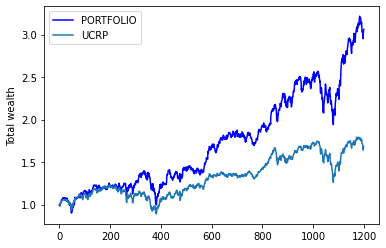

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.90
    Sharpe ratio: -0.48 ± 0.48
    Ulcer index: -0.30
    Information ratio (wrt UCRP): -2.16
    Appraisal ratio (wrt UCRP): -2.04 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.11 / -25.524%
    Annualized return: -13.27%
    Annualized volatility: 23.72%
    Longest drawdown: 1185 days
    Max drawdown: 63.85%
    Winning days: 49.3%
    Annual turnover: 377.8
        


<Figure size 720x360 with 0 Axes>

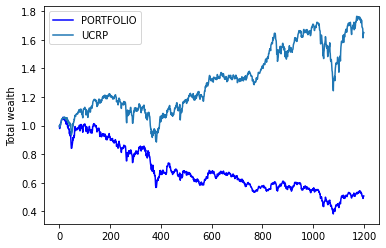

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.60
    Sharpe ratio: -2.88 ± 1.04
    Ulcer index: -0.88
    Information ratio (wrt UCRP): -7.27
    Appraisal ratio (wrt UCRP): -6.57 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.11 / -82.107%
    Annualized return: -50.81%
    Annualized volatility: 23.65%
    Longest drawdown: 1185 days
    Max drawdown: 96.76%
    Winning days: 41.5%
    Annual turnover: 377.8
        


<Figure size 720x360 with 0 Axes>

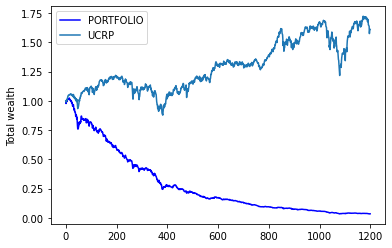

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.30
    Sharpe ratio: -6.89 ± 2.28
    Ulcer index: -1.81
    Information ratio (wrt UCRP): -15.72
    Appraisal ratio (wrt UCRP): -14.06 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.10 / -176.412%
    Annualized return: -80.94%
    Annualized volatility: 23.58%
    Longest drawdown: 1199 days
    Max drawdown: 99.96%
    Winning days: 30.1%
    Annual turnover: 377.8
        


<Figure size 432x288 with 0 Axes>

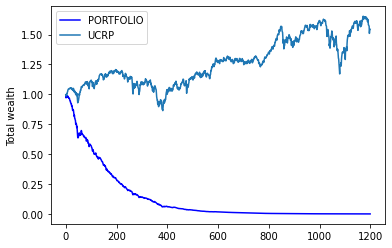


opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.18
    Sharpe ratio: 1.10 ± 0.58
    Ulcer index: 4.82
    Information ratio (wrt UCRP): 1.02
    Appraisal ratio (wrt UCRP): 0.84 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.17 / 16.356%
    Annualized return: 31.15%
    Annualized volatility: 28.40%
    Longest drawdown: 116 days
    Max drawdown: 26.05%
    Winning days: 53.8%
    Annual turnover: 432.5
        


<Figure size 720x360 with 0 Axes>

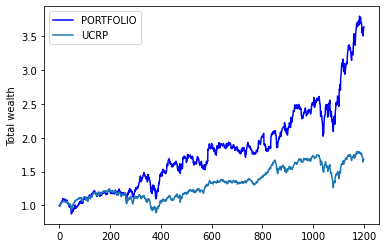

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.91
    Sharpe ratio: -0.43 ± 0.48
    Ulcer index: -0.28
    Information ratio (wrt UCRP): -1.37
    Appraisal ratio (wrt UCRP): -1.38 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.16 / -26.822%
    Annualized return: -14.85%
    Annualized volatility: 28.34%
    Longest drawdown: 1185 days
    Max drawdown: 69.57%
    Winning days: 49.2%
    Annual turnover: 432.5
        


<Figure size 720x360 with 0 Axes>

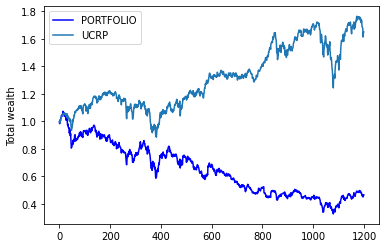

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.61
    Sharpe ratio: -2.72 ± 0.99
    Ulcer index: -0.96
    Information ratio (wrt UCRP): -4.96
    Appraisal ratio (wrt UCRP): -4.72 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.16 / -91.589%
    Annualized return: -55.52%
    Annualized volatility: 28.25%
    Longest drawdown: 1185 days
    Max drawdown: 98.06%
    Winning days: 40.7%
    Annual turnover: 432.5
        


<Figure size 720x360 with 0 Axes>

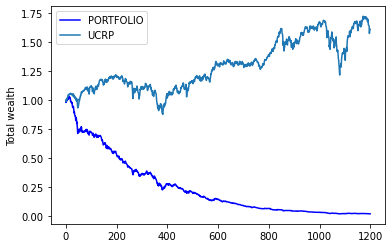

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.32
    Sharpe ratio: -6.57 ± 2.18
    Ulcer index: -2.03
    Information ratio (wrt UCRP): -10.93
    Appraisal ratio (wrt UCRP): -10.27 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.15 / -199.535%
    Annualized return: -84.99%
    Annualized volatility: 28.17%
    Longest drawdown: 1199 days
    Max drawdown: 99.99%
    Winning days: 30.8%
    Annual turnover: 432.5
        


<Figure size 432x288 with 0 Axes>

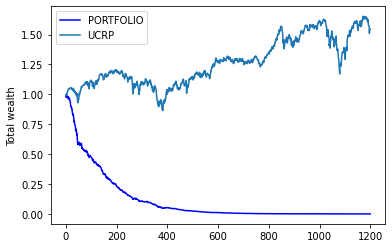


passive_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.12
    Sharpe ratio: 0.76 ± 0.52
    Ulcer index: 2.02
    Information ratio (wrt UCRP): 0.24
    Appraisal ratio (wrt UCRP): 0.31 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 2.219%
    Annualized return: 13.12%
    Annualized volatility: 18.55%
    Longest drawdown: 288 days
    Max drawdown: 28.25%
    Winning days: 54.2%
    Annual turnover: 12.5
        


<Figure size 720x360 with 0 Axes>

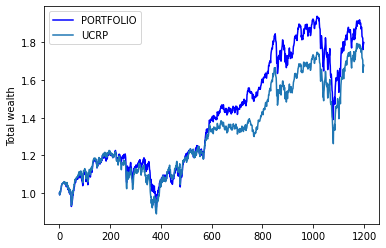

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 1.11
    Sharpe ratio: 0.69 ± 0.51
    Ulcer index: 1.76
    Information ratio (wrt UCRP): 0.02
    Appraisal ratio (wrt UCRP): 0.13 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 0.957%
    Annualized return: 11.70%
    Annualized volatility: 18.53%
    Longest drawdown: 351 days
    Max drawdown: 28.36%
    Winning days: 53.6%
    Annual turnover: 12.5
        


<Figure size 720x360 with 0 Axes>

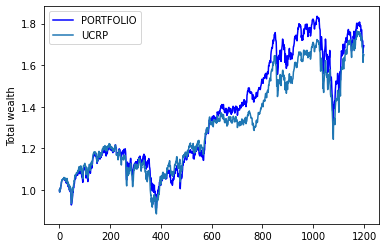

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.09
    Sharpe ratio: 0.59 ± 0.50
    Ulcer index: 1.37
    Information ratio (wrt UCRP): -0.31
    Appraisal ratio (wrt UCRP): -0.13 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / -0.936%
    Annualized return: 9.59%
    Annualized volatility: 18.52%
    Longest drawdown: 380 days
    Max drawdown: 28.51%
    Winning days: 53.2%
    Annual turnover: 12.5
        


<Figure size 720x360 with 0 Axes>

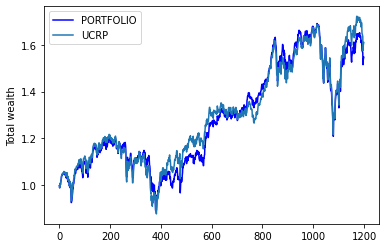

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.06
    Sharpe ratio: 0.42 ± 0.48
    Ulcer index: 0.82
    Information ratio (wrt UCRP): -0.85
    Appraisal ratio (wrt UCRP): -0.56 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / -4.092%
    Annualized return: 6.17%
    Annualized volatility: 18.50%
    Longest drawdown: 438 days
    Max drawdown: 28.77%
    Winning days: 52.6%
    Annual turnover: 12.5
        


<Figure size 432x288 with 0 Axes>

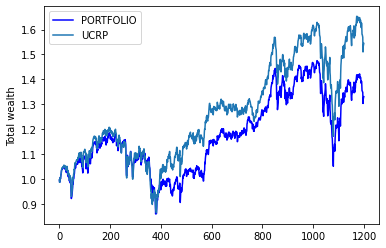

In [10]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results)

## HATS mat 0 + GGD

    #!/bin/bash

    maxiter=5000
    subn=100
    lb=5
    M=20
    inverse='True'
    ggd='True'
    matid=''

    matcnt=$(echo ${matid} | wc -w)
    for i in `seq 0 11`;
    # for i in 10;
    do
        echo "phase $i"
            python main2.py --phase $i --maxiter ${maxiter} --subn ${subn} --lb ${lb} --inverse ${inverse} --matid ${matid} --M ${M} --ggd ${ggd} --gpu 1  > ./log/main2_noval_inv${inverse}_ggd${ggd}_M${M}_iter${maxiter}_mat${matcnt}_subn${subn}_lb5_s5_log${i}.log
    done

In [11]:
paras={'dataset':'snp500-12', 'maxiter':5000, 'subn':100, 'lb':5, 'M':20, 'inverse':'True', 'ggd':'True', 'matcnt':0, 
       'c':0.001, 'rf':1e-3, 'opt_gamma':3, 'passive_eps':1.001, 'passive_delta':0.01}

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

Phase 0
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 1
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 2
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 3
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 4
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 5
Testing...
ucb_strategy
opt_strategy
passive_strategy


/home/linaiqi/anaconda3/envs/gpfinance/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Phase 6
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 7
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 8
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 9
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 10
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 11
Testing...
ucb_strategy
opt_strategy
passive_strategy

===========================overall results===========================
ucb_strategy
opt_strategy
passive_strategy


ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.18
    Sharpe ratio: 1.07 ± 0.57
    Ulcer index: 3.73
    Information ratio (wrt UCRP): 1.15
    Appraisal ratio (wrt UCRP): 0.91 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / 11.400%
    Annualized return: 25.55%
    Annualized volatility: 23.91%
    Longest drawdown: 238 days
    Max drawdown: 31.90%
    Winning days: 55.2%
    Annual turnover: 376.8
        


<Figure size 720x360 with 0 Axes>

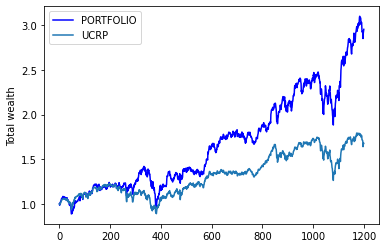

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.90
    Sharpe ratio: -0.50 ± 0.49
    Ulcer index: -0.30
    Information ratio (wrt UCRP): -2.21
    Appraisal ratio (wrt UCRP): -2.09 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / -26.227%
    Annualized return: -13.83%
    Annualized volatility: 23.85%
    Longest drawdown: 1185 days
    Max drawdown: 64.88%
    Winning days: 49.9%
    Annual turnover: 376.8
        


<Figure size 720x360 with 0 Axes>

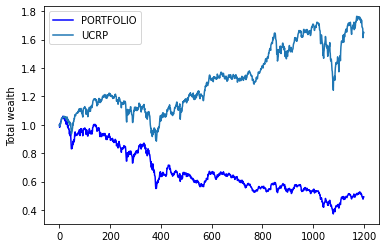

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.59
    Sharpe ratio: -2.88 ± 1.04
    Ulcer index: -0.88
    Information ratio (wrt UCRP): -7.27
    Appraisal ratio (wrt UCRP): -6.59 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / -82.666%
    Annualized return: -51.06%
    Annualized volatility: 23.78%
    Longest drawdown: 1185 days
    Max drawdown: 96.85%
    Winning days: 41.7%
    Annual turnover: 376.8
        


<Figure size 720x360 with 0 Axes>

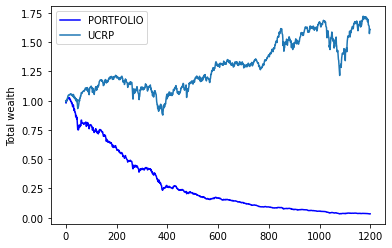

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.30
    Sharpe ratio: -6.86 ± 2.27
    Ulcer index: -1.81
    Information ratio (wrt UCRP): -15.65
    Appraisal ratio (wrt UCRP): -14.04 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.11 / -176.731%
    Annualized return: -80.99%
    Annualized volatility: 23.71%
    Longest drawdown: 1199 days
    Max drawdown: 99.96%
    Winning days: 29.8%
    Annual turnover: 376.8
        


<Figure size 432x288 with 0 Axes>

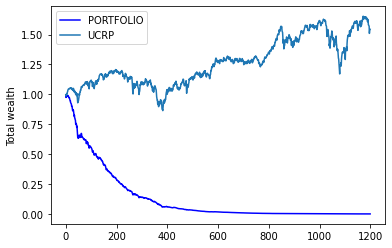


opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.16
    Sharpe ratio: 0.99 ± 0.56
    Ulcer index: 4.06
    Information ratio (wrt UCRP): 0.85
    Appraisal ratio (wrt UCRP): 0.69 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.17 / 13.455%
    Annualized return: 27.43%
    Annualized volatility: 28.61%
    Longest drawdown: 116 days
    Max drawdown: 30.26%
    Winning days: 53.2%
    Annual turnover: 431.8
        


<Figure size 720x360 with 0 Axes>

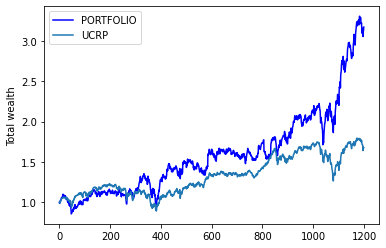

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.89
    Sharpe ratio: -0.52 ± 0.49
    Ulcer index: -0.30
    Information ratio (wrt UCRP): -1.50
    Appraisal ratio (wrt UCRP): -1.51 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.17 / -29.653%
    Annualized return: -17.21%
    Annualized volatility: 28.54%
    Longest drawdown: 1185 days
    Max drawdown: 73.08%
    Winning days: 49.0%
    Annual turnover: 431.8
        


<Figure size 720x360 with 0 Axes>

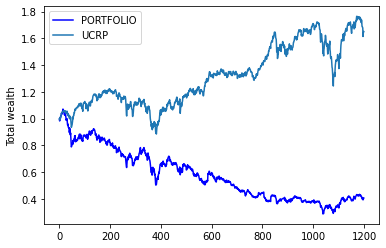

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.60
    Sharpe ratio: -2.79 ± 1.01
    Ulcer index: -0.98
    Information ratio (wrt UCRP): -5.05
    Appraisal ratio (wrt UCRP): -4.82 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.17 / -94.316%
    Annualized return: -56.71%
    Annualized volatility: 28.47%
    Longest drawdown: 1185 days
    Max drawdown: 98.25%
    Winning days: 40.8%
    Annual turnover: 431.8
        


<Figure size 720x360 with 0 Axes>

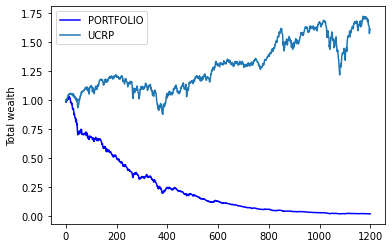

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.31
    Sharpe ratio: -6.60 ± 2.19
    Ulcer index: -2.05
    Information ratio (wrt UCRP): -10.95
    Appraisal ratio (wrt UCRP): -10.31 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.16 / -202.087%
    Annualized return: -85.36%
    Annualized volatility: 28.39%
    Longest drawdown: 1199 days
    Max drawdown: 99.99%
    Winning days: 30.8%
    Annual turnover: 431.8
        


<Figure size 432x288 with 0 Axes>

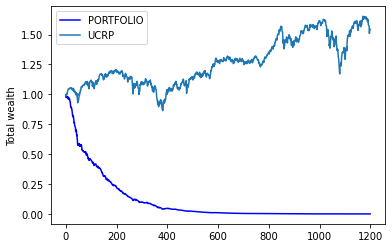


passive_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.12
    Sharpe ratio: 0.76 ± 0.52
    Ulcer index: 2.03
    Information ratio (wrt UCRP): 0.25
    Appraisal ratio (wrt UCRP): 0.32 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 2.309%
    Annualized return: 13.22%
    Annualized volatility: 18.54%
    Longest drawdown: 288 days
    Max drawdown: 28.33%
    Winning days: 53.9%
    Annual turnover: 12.4
        


<Figure size 720x360 with 0 Axes>

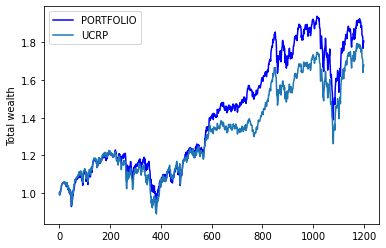

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 1.11
    Sharpe ratio: 0.69 ± 0.51
    Ulcer index: 1.77
    Information ratio (wrt UCRP): 0.04
    Appraisal ratio (wrt UCRP): 0.15 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 1.052%
    Annualized return: 11.80%
    Annualized volatility: 18.52%
    Longest drawdown: 351 days
    Max drawdown: 28.44%
    Winning days: 53.5%
    Annual turnover: 12.4
        


<Figure size 720x360 with 0 Axes>

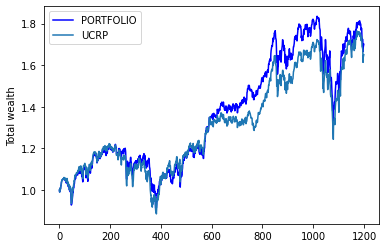

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.09
    Sharpe ratio: 0.59 ± 0.50
    Ulcer index: 1.39
    Information ratio (wrt UCRP): -0.29
    Appraisal ratio (wrt UCRP): -0.12 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / -0.834%
    Annualized return: 9.70%
    Annualized volatility: 18.51%
    Longest drawdown: 380 days
    Max drawdown: 28.59%
    Winning days: 53.0%
    Annual turnover: 12.4
        


<Figure size 720x360 with 0 Axes>

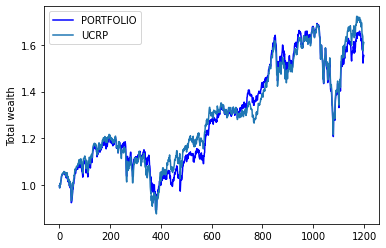

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.06
    Sharpe ratio: 0.42 ± 0.48
    Ulcer index: 0.84
    Information ratio (wrt UCRP): -0.83
    Appraisal ratio (wrt UCRP): -0.55 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / -3.977%
    Annualized return: 6.29%
    Annualized volatility: 18.49%
    Longest drawdown: 436 days
    Max drawdown: 28.86%
    Winning days: 52.5%
    Annual turnover: 12.4
        


<Figure size 432x288 with 0 Axes>

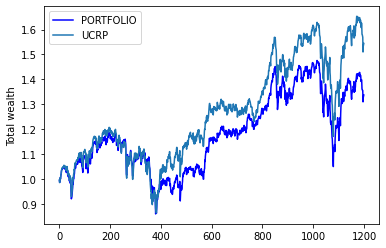

In [12]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results)

## HATS mat 30 + No GGD

    #!/bin/bash

    maxiter=5000
    subn=100
    lb=5
    M=20
    inverse='True'
    ggd='False'
    matid='48 35 83 25 84 19 21 71 24 68 81 38 51 56 77 43 80 15 30 60 69 37 73 62 34 54 57 70 39 42'

    matcnt=$(echo ${matid} | wc -w)
    for i in `seq 0 11`;
    # for i in 10;
    do
        echo "phase $i"
                python main2.py --phase $i --maxiter ${maxiter} --subn ${subn} --lb ${lb} --inverse ${inverse} --matid ${matid} --M ${M} --ggd ${ggd} --gpu 1  > ./log/main2_noval_inv${inverse}_ggd${ggd}_M${M}_iter${maxiter}_mat${matcnt}_subn${subn}_lb5_s5_log${i}.log
    done

In [13]:
paras={'dataset':'snp500-12', 'maxiter':5000, 'subn':100, 'lb':5, 'M':20, 'inverse':'True', 'ggd':'False', 'matcnt':30, 
       'c':0.001, 'rf':1e-3, 'opt_gamma':3, 'passive_eps':1.001, 'passive_delta':0.01}

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

Phase 0
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 1
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 2
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 3
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 4
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 5
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 6
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 7
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 8
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 9
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 10
Testing...
ucb_strategy
opt_strategy
passive_strategy
Phase 11
Testing...
ucb_strategy
opt_strategy
passive_strategy

===========================overall results===========================
ucb_strategy
opt_strategy
passive_strategy


TypeError: plot_cumulative_return_history() missing 1 required positional argument: 'c'

In [ ]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results)